<a href="https://colab.research.google.com/github/rushanmukherjee/GeospatialDataAnalytics/blob/main/Urban_Greenery_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Estimate Urban Greenery by Computing Tree Per Capita Index**

In [13]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

### Prepare Tree Dataframe

In [4]:
tree_df = pd.read_csv('2015_Street_Tree_Census_-_Tree_Data.csv')

In [14]:
geometry = [Point(xy) for xy in zip(tree_df['longitude'], tree_df['latitude'])]
tree_gdf = gpd.GeoDataFrame(tree_df, geometry = geometry)[['tree_id', 'stump_diam', 'status', 'health', 'geometry']]

In [17]:
tree_gdf.crs = 4326

In [18]:
tree_gdf.head(3)

,tree_id,stump_diam,status,health,geometry
0,180683,0,Alive,Fair,POINT (-73.84422 40.72309)
1,200540,0,Alive,Fair,POINT (-73.81868 40.79411)
2,204026,0,Alive,Good,POINT (-73.93661 40.71758)


In [6]:
pop_df = pd.read_csv('New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
len(pop_df)

390

In [8]:
gdf = gpd.read_file('2010 Neighborhood Tabulation Areas (NTAs).geojson')
print(len(gdf))

195


### Merge Population dataframes

In [9]:
pop_df = pop_df[pop_df.Year==2010]
codes_1 = set(pop_df['NTA Code'])
codes_2 = set(gdf['ntacode'])

In [10]:
len(codes_1), len(codes_2), len(codes_1.intersection(codes_2))

(195, 195, 195)

In [11]:
gdf_merged = gdf.merge(pop_df, right_on = 'NTA Code', left_on = 'ntacode')
gdf_merged.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",Brooklyn,2010,47,BK50,Canarsie,83693
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",Bronx,2010,5,BX41,Mount Hope,51807


### Merge Population Dataframe with Tree Dataframe

In [19]:
gdf_join = gpd.sjoin(gdf_merged, tree_gdf)
gdf_join.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,index_right,tree_id,stump_diam,status,health
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593,588794,104442,0,Alive,Good
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593,589984,104443,0,Alive,Good
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593,590258,104444,0,Alive,Good


### Extract Essential Data Columns

In [21]:
gdf_join = gdf_join[['NTA Name', 'Population', 'tree_id', 'geometry']]
gdf_join.head(3)

,NTA Name,Population,tree_id,geometry
0,St. Albans,48593,104442,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
0,St. Albans,48593,104443,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
0,St. Albans,48593,104444,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."


### Calculate number of unique trees in each neighborhood

In [22]:
gdf_grouped = gdf_join.groupby(by = 'NTA Name').nunique()[['tree_id']]
gdf_grouped = gdf_grouped.rename(columns = {'tree_id' : 'tree_count'})
gdf_grouped

,tree_count
NTA Name,
Airport,168
Allerton-Pelham Gardens,3852
Annadale-Huguenot-Prince's Bay-Eltingville,12977
Arden Heights,6994
Astoria,4388
...,...
Yorkville,2269
park-cemetery-etc-Bronx,1515
park-cemetery-etc-Brooklyn,1980


### Merge new information with Population Geodataframe

In [23]:
gdf_join_treeCount = gdf_merged.merge(gdf_grouped, left_on = 'NTA Name', right_index = True)
gdf_join_treeCount.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,tree_count
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593,7181
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",Brooklyn,2010,47,BK50,Canarsie,83693,5991
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",Bronx,2010,5,BX41,Mount Hope,51807,2000


### Calculate Tree Per Capita

In [24]:
gdf_join_treeCount['tree_per_capita'] = gdf_join_treeCount['tree_count'] / gdf_join_treeCount['Population']
gdf_join_treeCount.head(3)

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population,tree_count,tree_per_capita
0,QN08,77412747.756,081,St. Albans,45401.3169155,Queens,4,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",Queens,2010,81,QN08,St. Albans,48593,7181,0.147778
1,BK50,82089678.5561,047,Canarsie,43703.6099368,Brooklyn,3,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",Brooklyn,2010,47,BK50,Canarsie,83693,5991,0.071583
2,BX41,14716710.849,005,Mount Hope,18937.2480746,Bronx,2,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",Bronx,2010,5,BX41,Mount Hope,51807,2000,0.038605


### Sort Dataframe in descending order

In [37]:
gdf_join_treeCount = gdf_join_treeCount.sort_values(by = 'tree_per_capita', ascending = False)
gdf_join_treeCount = gdf_join_treeCount[gdf_join_treeCount['tree_per_capita'] != float('inf')] ##Remove Infinity Values

In [34]:
gdf_join_treeCount[['NTA Name','tree_count', 'Population', 'tree_per_capita']].head(10)

,NTA Name,tree_count,Population,tree_per_capita
192,park-cemetery-etc-Queens,2259,436,5.181193
115,park-cemetery-etc-Brooklyn,1980,418,4.736842
171,park-cemetery-etc-Bronx,1515,1906,0.794858
191,park-cemetery-etc-Manhattan,1251,1849,0.676582
176,Annadale-Huguenot-Prince's Bay-Eltingville,12977,27770,0.467303
177,Rossville-Woodrow,9248,20763,0.445408
16,Charleston-Richmond Valley-Tottenville,8213,23313,0.352293
13,Glen Oaks-Floral Park-New Hyde Park,6690,22571,0.296398
91,Douglas Manor-Douglaston-Little Neck,7206,24739,0.291281
89,Arden Heights,6994,25238,0.277122


In [35]:
import matplotlib.pyplot as plt

(np.float64(-74.28337047814922),
 np.float64(-73.67222994821337),
 np.float64(40.47516404814219),
 np.float64(40.93650271647436))

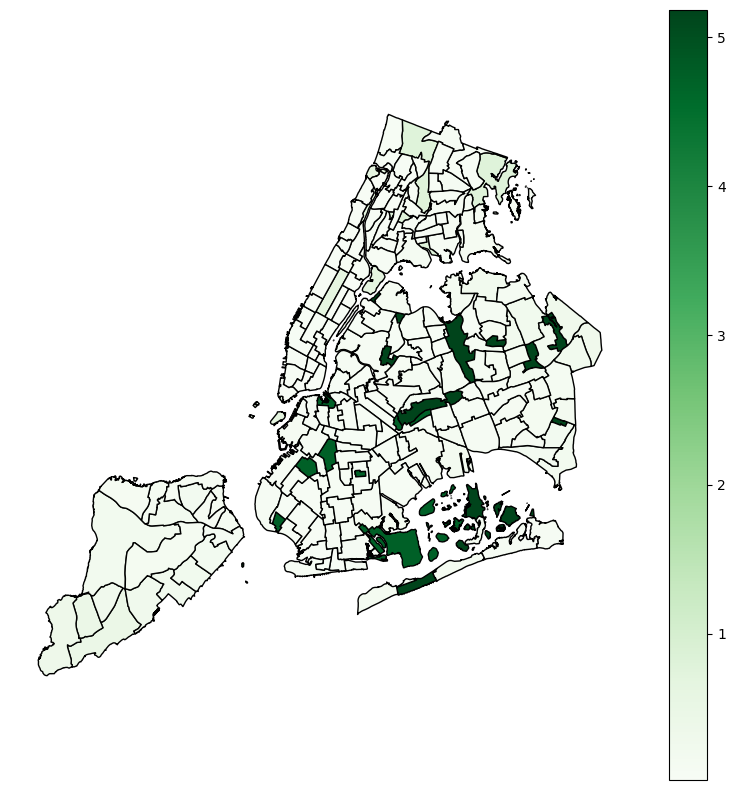

In [36]:
f, ax = plt.subplots(1, figsize = (10, 10))
gdf_join_treeCount.plot(column = 'tree_per_capita', cmap='Greens', ax = ax, edgecolor= 'k', legend = True)
ax.axis('off')

In [40]:
from matplotlib.colors import LogNorm

##create Normalisation Function for Better Visibility
norm = LogNorm(vmin = gdf_join_treeCount['tree_per_capita'].min(),
               vmax = gdf_join_treeCount['tree_per_capita'].max())

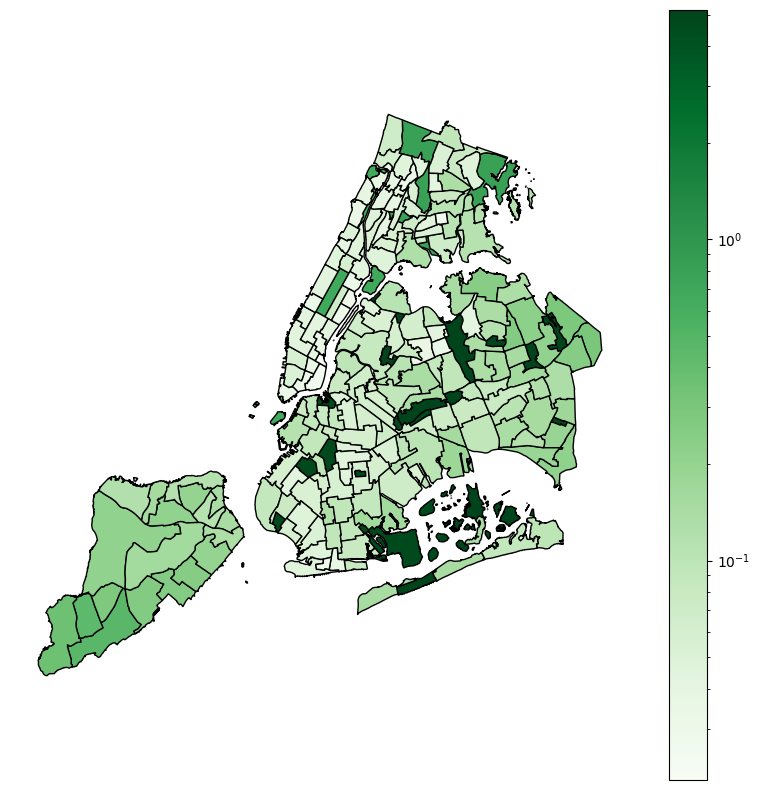

In [42]:
f, ax = plt.subplots(1, figsize = (10, 10))
gdf_join_treeCount.plot(column = 'tree_per_capita',
                        cmap='Greens',
                        ax = ax,
                        edgecolor= 'k',
                        norm = norm,
                        legend = True)
ax.axis('off')
plt.show()